### Catboost2
* added feature engineering

In [1]:
import pandas as pd
import numpy as np
import catboost as cat

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print(cat.__version__)

1.0.4


In [3]:
# globals
FIGSIZE = (9, 6)

SEED = 42

FILE_TRAIN = "train.csv"

In [4]:
#
# my split in train, test set
#
def my_train_test_split(df, frac):
    # frac: the fraction used for train
    # df: the dataframe
    
    # shuffle before split
    df = df.sample(frac=1., random_state=SEED)

    # FRAC = 0.90
    tot_rec = df.shape[0]
    NUM_TRAIN = int(frac*tot_rec)
    NUM_TEST = tot_rec - NUM_TRAIN

    data_train = df[:NUM_TRAIN]
    data_test = df[NUM_TRAIN:]

    print()
    print('Numero totale di campioni:', tot_rec)
    print('Numero di campioni nel TRAIN SET:', data_train.shape[0])
    print('Numero di campioni nel TEST SET:', data_test.shape[0])
    
    return data_train, data_test

In [5]:
data_orig = pd.read_csv(FILE_TRAIN)

# feature engineering
data_orig['datetime'] = pd.to_datetime(data_orig['datetime'])

# this way I add 3 engineered features
data_orig['hour'] = data_orig['datetime'].dt.hour

# mese di fatto è duplicato di season. rimuovo
#data_orig['month'] = data_orig['datetime'].dt.month
data_orig['day'] = data_orig['datetime'].dt.day

In [6]:
data_orig.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,19
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,19
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,19
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23,19


In [7]:
all_columns = data_orig.columns

# colonne da ignorare
# atemp and temp are strongly correlated (0.98) taking only one
del_columns = ['datetime', 'casual', 'registered', 'temp']

TARGET = "count"

cat_cols = ['season', 'holiday','workingday', 'weather', 'hour', 'day']

num_cols = list(set(all_columns) - set([TARGET]) - set(del_columns) - set(cat_cols))

features = sorted(cat_cols + num_cols)

print('Tutte le colonne:', len(all_columns))
print('Colonne ignorate:', len(del_columns))
print('target:', len([TARGET]))
print('Colonne cat:', len(cat_cols))
print('Colonne num:', len(num_cols))
print('Num. features', len(features))

Tutte le colonne: 14
Colonne ignorate: 4
target: 1
Colonne cat: 6
Colonne num: 3
Num. features 9


In [8]:
data_used = data_orig.drop(del_columns, axis=1)

In [9]:
FRAC = 0.90

data_train, data_test = my_train_test_split(data_used, frac=FRAC)


Numero totale di campioni: 10886
Numero di campioni nel TRAIN SET: 9797
Numero di campioni nel TEST SET: 1089


In [10]:
# separo X ed y
x_train = data_train[features]
y_train = data_train[TARGET]

x_test = data_test[features]
y_test = data_test[TARGET]

# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(x_train.columns) if col in cat_cols]

In [11]:
%%time

params = {'iterations':6000,
          'learning_rate':0.005,
          'depth':10,
          # 'task_type':"GPU"
         }

model = cat.CatBoostRegressor(**params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=500, early_stopping_rounds=50, eval_set=(x_test, y_test))

0:	learn: 180.9718627	test: 176.8873673	best: 176.8873673 (0)	total: 87.6ms	remaining: 8m 45s
500:	learn: 83.4735377	test: 79.2701561	best: 79.2701561 (500)	total: 7.78s	remaining: 1m 25s
1000:	learn: 73.5305389	test: 72.4681757	best: 72.4681757 (1000)	total: 15.7s	remaining: 1m 18s
1500:	learn: 68.7768482	test: 70.3165088	best: 70.3165088 (1500)	total: 23s	remaining: 1m 9s
2000:	learn: 64.7860583	test: 68.8216838	best: 68.8216838 (2000)	total: 30.9s	remaining: 1m 1s
2500:	learn: 61.1429045	test: 67.5281829	best: 67.5281829 (2500)	total: 38.8s	remaining: 54.3s
3000:	learn: 58.3346487	test: 66.6258815	best: 66.6258815 (3000)	total: 46.8s	remaining: 46.8s
3500:	learn: 55.7759773	test: 65.9029720	best: 65.9029720 (3500)	total: 55.3s	remaining: 39.5s
4000:	learn: 53.2177725	test: 65.2955311	best: 65.2954906 (3999)	total: 1m 3s	remaining: 31.9s
4500:	learn: 51.0985782	test: 64.8654527	best: 64.8642312 (4495)	total: 1m 12s	remaining: 24.1s
5000:	learn: 49.1901263	test: 64.5545690	best: 64.55

In [12]:
history = model.evals_result_

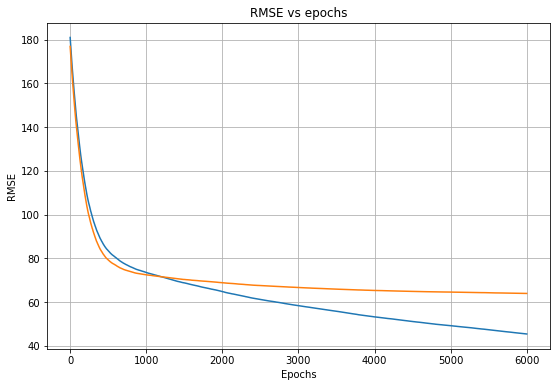

In [13]:
plt.figure(figsize=FIGSIZE)
plt.title('RMSE vs epochs')
plt.plot(history['learn']['RMSE'])
plt.plot(history['validation']['RMSE'])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.grid(True)
plt.show();

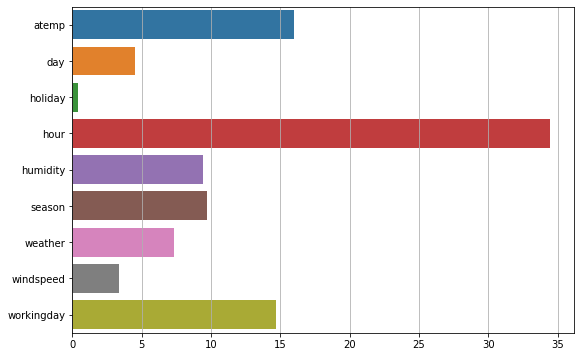

In [14]:
%matplotlib inline

# eXplainability: Feature importance


plt.figure(figsize = FIGSIZE)
plt.grid(True)
sns.barplot(x = model.get_feature_importance(), y = features);

### Submission

In [ ]:
test_orig = pd.read_csv("test.csv")

In [ ]:
# add engineered features
# feature engineering
test_orig['datetime'] = pd.to_datetime(test_orig['datetime'])

# this way I add 3 engineered features
test_orig['hour'] = test_orig['datetime'].dt.hour
#test_orig['month'] = test_orig['datetime'].dt.month
test_orig['day'] = test_orig['datetime'].dt.day

In [ ]:
v_test = test_orig[features]

In [ ]:
score_test = model.predict(v_test)

In [ ]:
df_sub = pd.read_csv("sampleSubmission.csv")

In [ ]:
df_sub["count"] = score_test

In [ ]:
condition = df_sub["count"] < 0

df_sub.loc[condition, "count"] = 0

In [ ]:
df_sub.describe()

In [ ]:
FILE_SUB = "submission6.csv"

df_sub.to_csv(FILE_SUB, index=False)

In [ ]:
!kaggle competitions submit -c "bike-sharing-demand" -f $FILE_SUB -m "sub6"